In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
#import matplotlib.pyplot as plt

In [2]:
# pip install matplotlib

# Data Collection

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [4]:
# bring data 
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Early_blight', 'Late_blight', 'healthy']

In [6]:
len(dataset)

68

In [7]:
# 32 images , 256 * 256 , 3 = rpg et on a 3 classe 0 1 et 2
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


In [8]:
# bch nthahrou ken taswira loula 
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())


[[[163. 161. 172.]
  [129. 127. 138.]
  [108. 106. 117.]
  ...
  [163. 161. 175.]
  [158. 156. 170.]
  [153. 151. 165.]]

 [[149. 147. 158.]
  [ 98.  96. 107.]
  [144. 142. 153.]
  ...
  [159. 157. 171.]
  [165. 163. 177.]
  [168. 166. 180.]]

 [[100.  98. 109.]
  [117. 115. 126.]
  [188. 186. 199.]
  ...
  [163. 161. 175.]
  [164. 162. 176.]
  [164. 162. 176.]]

 ...

 [[142. 138. 153.]
  [120. 116. 131.]
  [136. 132. 147.]
  ...
  [180. 178. 191.]
  [178. 176. 189.]
  [189. 187. 200.]]

 [[118. 114. 129.]
  [102.  98. 113.]
  [157. 153. 168.]
  ...
  [177. 175. 188.]
  [172. 170. 183.]
  [177. 175. 188.]]

 [[123. 119. 134.]
  [128. 124. 139.]
  [148. 144. 159.]
  ...
  [205. 203. 216.]
  [188. 186. 199.]
  [173. 171. 184.]]]


In [9]:
# visualise this image
#hiyya float bch nbadlelha type
# plt.figure(figsize=(10, 10))
# for image_batch, labels_batch in dataset.take(1):
#     for i in range(12):
#         ax = plt.subplot(3, 4, i + 1)
#         plt.imshow(image_batch[i].numpy().astype("uint8"))
#         plt.title(class_names[labels_batch[i]])
#         plt.axis("off")

In [10]:
len(dataset)

68

In [11]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [12]:
train_ds = dataset.take(54)
len(train_ds)

54

In [13]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [14]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [15]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [16]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [17]:
import numpy as np

In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)
    if shuffle :
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int( val_split * ds_size)

    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds
    

In [19]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [20]:
len(train_ds)

54

In [21]:
len(val_ds)

6

In [22]:
len(test_ds)

8

### Cache, Shuffle, and Prefetch the Dataset

In [23]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Building the Model

### Creating a Layer for Resizing and Normalization

In [24]:
print(tf.__version__)

2.18.0


In [25]:
# pip install --upgrade tensorflow

In [26]:
IMAGE_SIZE = 255  # Remplace par la taille désirée
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])

## Data Augmentation

#### Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [27]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [28]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

#### We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation

In [29]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)   # hauteur largeur rgb
n_classes = 3

model = models.Sequential([      # crée un modèle séquentiel, où les couches sont empilées les unes sur les autres
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

C:\Users\saber\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
model.summary() 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 255, 255, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 253, 253, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 126, 126, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 124, 124, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

### Compiling the Model

In [31]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),    #SparseCategoricalCrossentropy : Cette fonction de perte est utilisée pour les problèmes de classification multi-classes, où les étiquettes de classe sont des entiers (par exemple, 0, 1, 2 pour trois classes).
    metrics=['accuracy']       #  C'est une métrique standard pour évaluer la performance des modèles de classification.
)

In [32]:
#La méthode fit est utilisée pour entraîner le modèle sur les données d'entraînement.
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.4923 - loss: 0.9336 - val_accuracy: 0.6458 - val_loss: 0.7316
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.7037 - loss: 0.6290 - val_accuracy: 0.6979 - val_loss: 0.5571
Epoch 3/50
14/54 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - accuracy: 0.7842 - loss: 0.4697

KeyboardInterrupt: 

In [ ]:
scores = model.evaluate(test_ds)
# You can see above that we get 100.00% accuracy for our test dataset. This is considered to be a pretty good accuracy

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - accuracy: 0.8769 - loss: 0.2927


In [ ]:
scores

[0.30329591035842896, 0.8828125]

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [ ]:
history.history.keys()
# oss, accuracy,val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

50

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9246090650558472,
 0.6813849210739136,
 0.4068322777748108,
 0.3143419921398163,
 0.2680916488170624]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

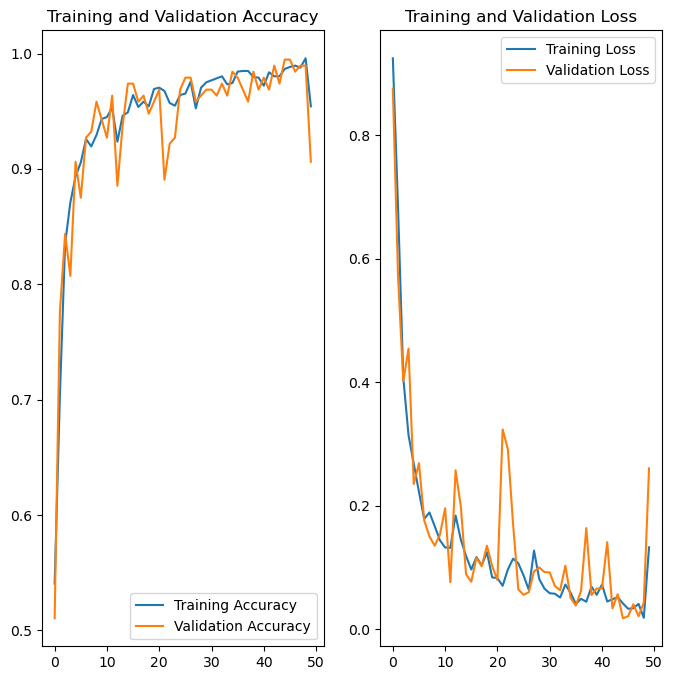

In [ ]:
# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(range(EPOCHS), acc, label='Training Accuracy')
# plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(range(EPOCHS), loss, label='Training Loss')
# plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

# #ahayka accurancy mechya w tet7asen w lose mechi w yon9os

### Run prediction on a sample image

first image to predict
actual label: Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
predicted label: Early_blight


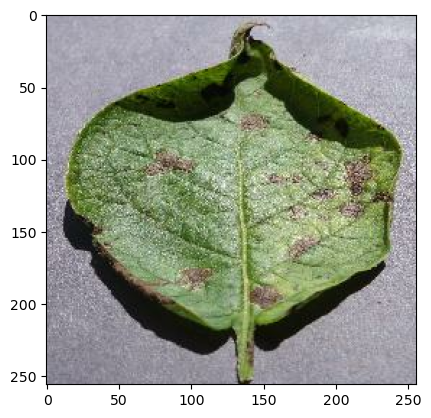

In [ ]:
# import numpy as np
# for images_batch, labels_batch in test_ds.take(1):
    
#     first_image = images_batch[0].numpy().astype('uint8')
#     first_label = labels_batch[0].numpy()
    
#     print("first image to predict")
#     plt.imshow(first_image)
#     print("actual label:",class_names[first_label])
    
#     batch_prediction = model.predict(images_batch)
#     print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# Test prediction avec le path de l'image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


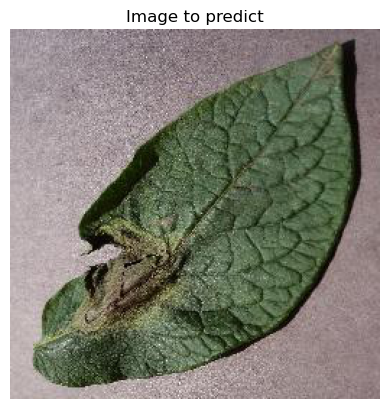

Predicted label: healthy


In [ ]:
from tensorflow.keras.preprocessing import image
# Fonction pour charger et préparer une image à partir d'un chemin
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)  # Charger l'image
    img_array = image.img_to_array(img)  # Convertir en tableau numpy
    img_array = np.expand_dims(img_array, axis=0)  # Ajouter une dimension pour le batch
    img_array = img_array / 255.0  # Normaliser si nécessaire
    return img_array

def predict_image(image_path, model, class_names, target_size=(224, 224)):
    # Load and preprocess the image
    img_to_predict = load_and_preprocess_image(image_path, target_size)
    
    # Make the prediction
    batch_prediction = model.predict(img_to_predict)
    
    # Get the predicted label
    predicted_label = class_names[np.argmax(batch_prediction[0])]
    
    return predicted_label

# Dynamic image path
image_path = input("Enter the path to the image: ")
predicted_label = predict_image(image_path, model, class_names)
print("Predicted label:", predicted_label)
 
# # Spécifier le chemin de l'image à prédire
# image_path ="C:/Users/bensa/deeplearningProjet1/IOTProjet/PlantVillage/Late_blight/0f1fb568-1b12-45ef-ad99-c59fa9075693___RS_LB 3242.JPG"
# # Charger et préparer l'image
# img_to_predict = load_and_preprocess_image(image_path)

# # Faire la prédiction
# batch_prediction = model.predict(img_to_predict)

# # Afficher l'image
# img = image.load_img(image_path)
# plt.imshow(img)
# plt.title("Image to predict")
# plt.axis("off")  # Masquer les axes
# plt.show()

# Afficher le label prédit
# predicted_label = class_names[np.argmax(batch_prediction[0])]
# print("Predicted label:", predicted_label)

### Write a function for inference

In [ ]:
# def predict(model, img):
#     img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
#     img_array = tf.expand_dims(img_array, 0)

#     predictions = model.predict(img_array)

#     predicted_class = class_names[np.argmax(predictions[0])]
#     confidence = round(100 * (np.max(predictions[0])), 2)
#     return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


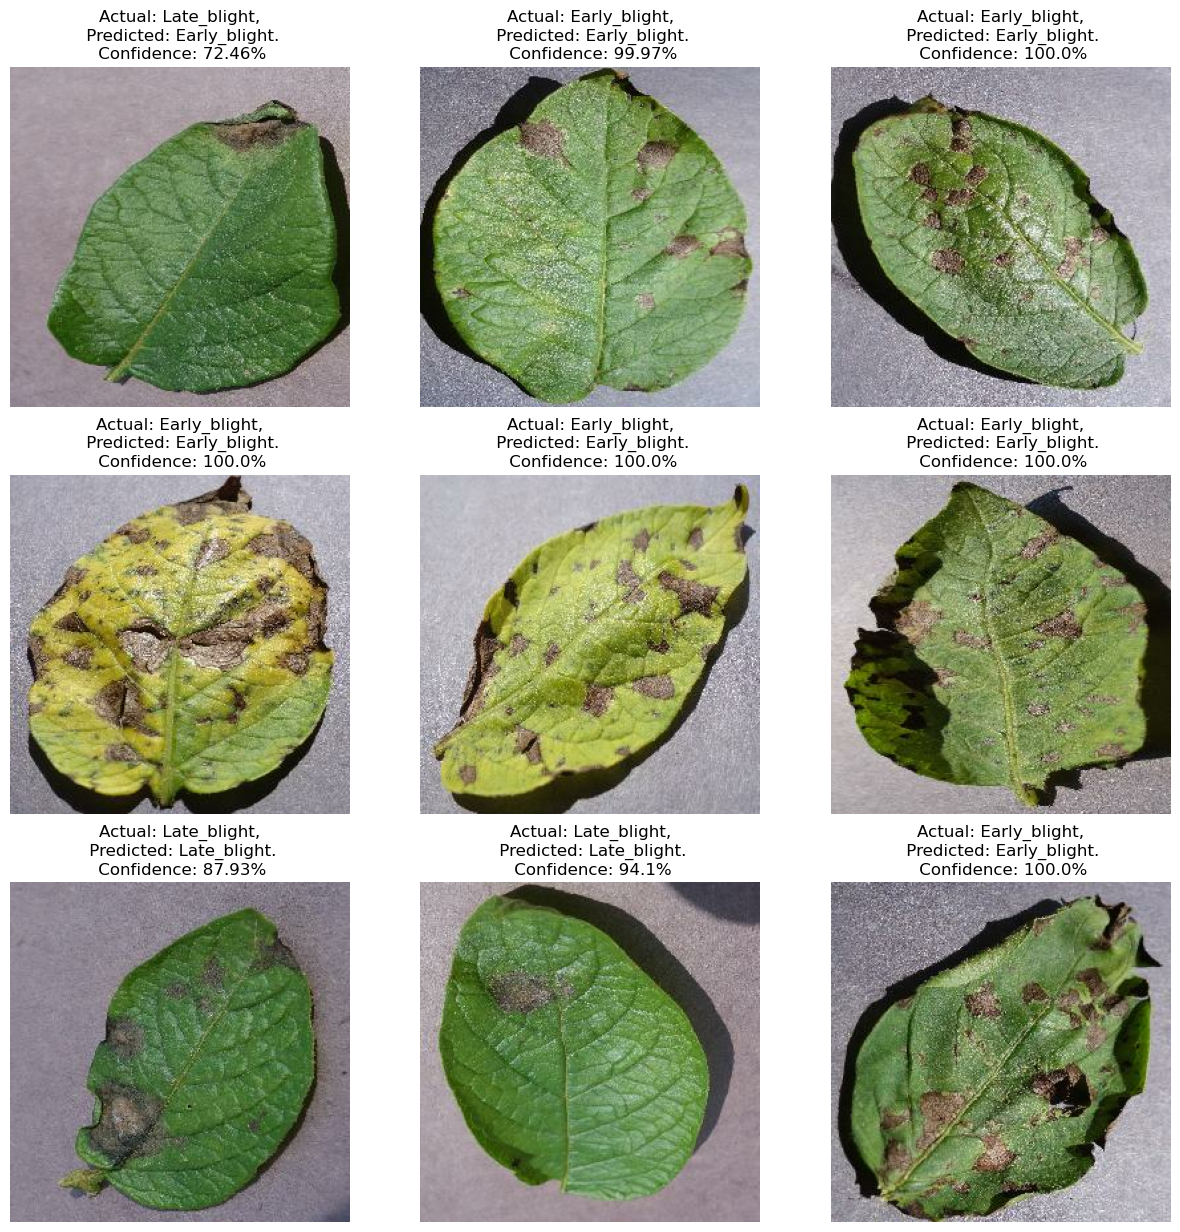

In [ ]:
# # Now run inference on few sample images 
# plt.figure(figsize=(15, 15))
# for images, labels in test_ds.take(1):
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
        
#         predicted_class, confidence = predict(model, images[i].numpy())
#         actual_class = class_names[labels[i]] 
        
#         plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
#         plt.axis("off")

In [1]:
# import tensorflow as tf

# # Sauvegarder le modèle entier
# model.save('mon_modele1.h5') 
# # Sauvegarder uniquement les poids
# model.save_weights("poids_de_mon_modele.h5")

model.save("mon_modeleDeepLearning.h5")

NameError: name 'model' is not defined